# 850-hPa Geopotential Heights, Temperature, & Winds

In [1]:
# Import Python modules
import os, sys
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import matplotlib.ticker as mticker
from matplotlib.gridspec import GridSpec
import metpy.calc as mpcalc
from metpy.units import units
import cmocean
import cmocean.cm as cmo
from scipy.ndimage import gaussian_filter

In [2]:
# Import my modules
sys.path.append('/Users/tessamontini/repos/montini-phd/modules/')

# Root directories
savedir = '/Users/tessamontini/Desktop/res/'
datadir = '/Users/tessamontini/Google_Drive/DATA/'

## Data Processing

### SALLJ days

In [3]:
# Daily SALLJ time series
infile = datadir + 'sallj/erai.llj.day.1979-2016.csv'
df = pd.read_csv(infile)

# Create column `llj1` where: 0=No LLJ; 1=LLJ at SC or MA
idx = (df['llj_sc'] > 0) | (df['llj_ma'] > 0)
df['llj1'] = 0
df.loc[idx, 'llj1'] = 1

#df.head()

### ERA5 renalysis

In [4]:
# read in data files
f1 = xr.open_dataset(datadir+'ERA5/day/era5_zg_850_day_1979-2016_spac.nc')
f2 = xr.open_dataset(datadir+'ERA5/day/era5_ua_850_day_1979-2016_spac.nc')
f3 = xr.open_dataset(datadir+'ERA5/day/era5_va_850_day_1979-2016_spac.nc')
f4 = xr.open_dataset(datadir+'ERA5/day/era5_ta_850_day_1979-2016_spac.nc')

# Merge variables into one dataset
era = xr.merge([f1,f2,f3,f4])
print(era, '\n')

# Add LLJ time series to era dataset
era['llj1'] = ('time', df.llj1)
era = era.set_coords('llj1')

# Subset dataset to only DJF LLJ days
idx = (era.time.dt.season == 'DJF') & (era.llj1 >= 1)
era_llj = era.sel(time=idx)
print(era_llj)

<xarray.Dataset>
Dimensions:    (bnds: 2, latitude: 161, longitude: 307, time: 13880)
Coordinates:
  * longitude  (longitude) float32 -165.0 -164.5 -164.0 ... -13.0 -12.5 -12.0
  * latitude   (latitude) float32 20.0 19.5 19.0 18.5 ... -59.0 -59.5 -60.0
  * time       (time) datetime64[ns] 1979-01-01T09:00:00 ... 2016-12-31T09:00:00
Dimensions without coordinates: bnds
Data variables:
    time_bnds  (time, bnds) datetime64[ns] 1979-01-01 ... 2016-12-31T18:00:00
    zg         (time, latitude, longitude) float32 ...
    ua         (time, latitude, longitude) float32 ...
    va         (time, latitude, longitude) float32 ...
    ta         (time, latitude, longitude) float32 ... 

<xarray.Dataset>
Dimensions:    (bnds: 2, latitude: 161, longitude: 307, time: 1184)
Coordinates:
  * longitude  (longitude) float32 -165.0 -164.5 -164.0 ... -13.0 -12.5 -12.0
  * latitude   (latitude) float32 20.0 19.5 19.0 18.5 ... -59.0 -59.5 -60.0
  * time       (time) datetime64[ns] 1979-01-01T09:00:00 ... 

### Mask elevations > 1500 m

In [5]:
# ERA5 orography data
fx = xr.open_dataset(datadir+'ERA5/era5_sfc_orog_spac.nc')
fx = fx.isel(time=0, drop=True)

# Add orog to era_llj dataset
era_llj['orog'] = (('latitude','longitude'), fx.orog)

# Mask elevations > 1500 m
era_llj = era_llj.where(era_llj.orog < 1500)
print(era_llj)


<xarray.Dataset>
Dimensions:    (bnds: 2, latitude: 161, longitude: 307, time: 1184)
Coordinates:
  * longitude  (longitude) float32 -165.0 -164.5 -164.0 ... -13.0 -12.5 -12.0
  * latitude   (latitude) float32 20.0 19.5 19.0 18.5 ... -59.0 -59.5 -60.0
  * time       (time) datetime64[ns] 1979-01-01T09:00:00 ... 2016-12-31T09:00:00
    llj1       (time) int64 1 1 1 1 1 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1 1 1 1 1 1
Dimensions without coordinates: bnds
Data variables:
    time_bnds  (time, bnds, latitude, longitude) datetime64[ns] 1979-01-01 ... 2016-12-31T18:00:00
    zg         (time, latitude, longitude) float32 1515.5709 ... 1092.8843
    ua         (time, latitude, longitude) float32 -6.8414273 ... -0.26343673
    va         (time, latitude, longitude) float32 -5.2097526 ... 4.29512
    ta         (time, latitude, longitude) float32 282.72244 ... 265.00314
    orog       (latitude, longitude) float64 0.1355 -0.3303 ... -0.0974 -0.2527


### SALLJ days by category

In [6]:
# Read in category data
infile = savedir + 'sallj_types_exp5.csv'
dftype = pd.read_csv(infile)
#dftype.head()

# Add LLJ category labels to era_llj dataset
era_llj['llj_types'] = ('time', dftype.llj_types)
era_llj = era_llj.set_coords('llj_types')
print(era_llj)


<xarray.Dataset>
Dimensions:    (bnds: 2, latitude: 161, longitude: 307, time: 1184)
Coordinates:
  * longitude  (longitude) float32 -165.0 -164.5 -164.0 ... -13.0 -12.5 -12.0
  * latitude   (latitude) float32 20.0 19.5 19.0 18.5 ... -59.0 -59.5 -60.0
  * time       (time) datetime64[ns] 1979-01-01T09:00:00 ... 2016-12-31T09:00:00
    llj1       (time) int64 1 1 1 1 1 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1 1 1 1 1 1
    llj_types  (time) int64 2 2 2 2 2 2 2 1 1 2 2 1 ... 2 2 1 3 3 1 2 3 3 1 3 3
Dimensions without coordinates: bnds
Data variables:
    time_bnds  (time, bnds, latitude, longitude) datetime64[ns] 1979-01-01 ... 2016-12-31T18:00:00
    zg         (time, latitude, longitude) float32 1515.5709 ... 1092.8843
    ua         (time, latitude, longitude) float32 -6.8414273 ... -0.26343673
    va         (time, latitude, longitude) float32 -5.2097526 ... 4.29512
    ta         (time, latitude, longitude) float32 282.72244 ... 265.00314
    orog       (latitude, longitude) float64 0.1355 -

### Composites of SALLJ types

In [7]:
# calc field average for each LLJ category
era_llj_comp = era_llj.groupby('llj_types').mean('time')
print(era_llj_comp)


/Users/tessamontini/miniconda3/envs/montini-phd/lib/python3.7/site-packages/xarray/core/nanops.py:160: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


<xarray.Dataset>
Dimensions:    (latitude: 161, llj_types: 3, longitude: 307)
Coordinates:
  * longitude  (longitude) float32 -165.0 -164.5 -164.0 ... -13.0 -12.5 -12.0
  * latitude   (latitude) float32 20.0 19.5 19.0 18.5 ... -59.0 -59.5 -60.0
  * llj_types  (llj_types) int64 1 2 3
Data variables:
    zg         (llj_types, latitude, longitude) float32 1521.2327 ... 1169.9756
    ua         (llj_types, latitude, longitude) float32 -3.2616193 ... 3.9660895
    va         (llj_types, latitude, longitude) float32 -0.09352357 ... 1.7189935
    ta         (llj_types, latitude, longitude) float32 286.74442 ... 266.34412
    orog       (llj_types, latitude, longitude) float64 0.1355 ... -0.2527


### Data for plotting

In [8]:
# Lat/Lon values
lats = era_llj_comp.latitude.values
lons = era_llj_comp.longitude.values

# 850-hPa Heights
hgts = era_llj_comp.zg.values

# 850-hPa Winds
uwnd = era_llj_comp.ua.values * units('m/s')
vwnd = era_llj_comp.va.values * units('m/s')
wspd = mpcalc.wind_speed(uwnd, vwnd)
wspd_kt = wspd.to('kt')

# 850-hPa Temperature
tmpk = era_llj_comp.ta.values * units('K')
tmpc = tmpk.to('degC')


In [9]:
# Print data ranges (min/max values)
print('hgts:', hgts.min(), hgts.max(), '\n')
print('wspd:', wspd.min(), wspd.max(), '\n')
print('wspd (kt):', wspd_kt.min(), wspd_kt.max(), '\n')
print('tmpc:', tmpc.min(), tmpc.max(), '\n')

hgts: nan nan 

wspd: nan meter / second nan meter / second 

wspd (kt): nan knot nan knot 

tmpc: nan degC nan degC 



## Map Creation

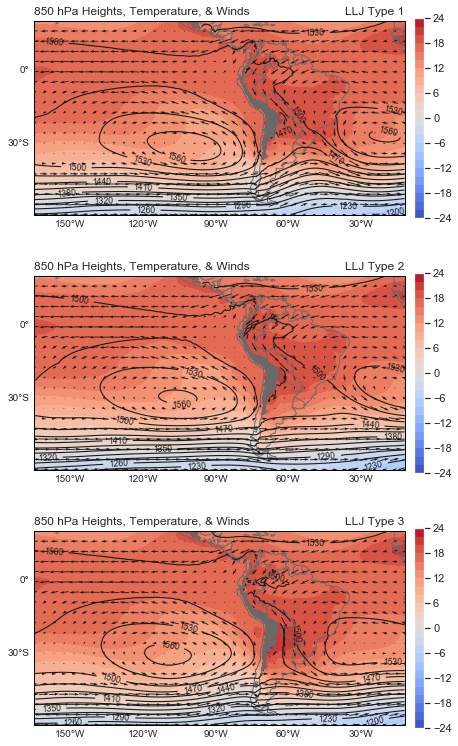

In [11]:
# Figure set up
nplots = 3
nrows = 3
ncols = 1

# Subplot labels
type_label = ['LLJ Type 1', 'LLJ Type 2', 'LLJ Type 3']

# Set up projection
mapcrs = ccrs.PlateCarree()
datacrs = ccrs.PlateCarree()

# Create figure
fig = plt.figure(figsize=(8,11))
gs = GridSpec(3, 1, figure=fig, hspace=0.02, top=0.97, bottom=0.01)

# Loop through each subplot 
for k in range(nplots):
      
    # Add plot axes and set map extent
    ax = fig.add_subplot(gs[k,0], projection=mapcrs)
    ax.set_extent([-165, -12, -60, 20], crs=mapcrs)
    
    # Add map features (coastlines, country borders)
    ax.add_feature(cfeature.COASTLINE, edgecolor='dimgrey')
    ax.add_feature(cfeature.BORDERS, edgecolor='dimgrey')
    ax.add_feature(cfeature.LAND, color='dimgrey')
    
    # Plot 850-hPa Temperature (color fill)
    clevs_tmpc = np.arange(-24, 25, 2)
    cf = ax.contourf(lons, lats, tmpc[k,:,:], transform=datacrs,
                    levels=clevs_tmpc, cmap='coolwarm')
    cb = plt.colorbar(cf, orientation='vertical', pad=0.02, shrink=0.8)
    
    # Geopotenital height lines
    #clevs_hgts = np.arange(1080,1280,12)
    clevs_hgts = np.arange(0, 1800, 30)
    cs = ax.contour(lons, lats, hgts[k,:,:], transform=datacrs,
                    levels=clevs_hgts, colors='k', linewidths=1.1)
    plt.clabel(cs, fmt='%d',fontsize=8.5)    
        
    # Wind barbs / vectors 
    ax.quiver(lons, lats, uwnd[k,:,:], vwnd[k,:,:], transform=datacrs, 
            color='k', regrid_shape=20, pivot='middle')
   
    # subtitles
    ax.set_title(type_label[k], loc='right')
    ax.set_title('850 hPa Heights, Temperature, & Winds', loc='left')
    
    # Tick labels (no gridlines)
    dx = np.arange(-180,31,30)
    dy = np.arange(-60,61,30)
    gl = ax.gridlines(crs=mapcrs, draw_labels=True)
    gl.xlines = False
    gl.ylines = False
    gl.xlabels_top = False
    gl.ylabels_right = False
    gl.xlocator = mticker.FixedLocator(dx)
    gl.ylocator = mticker.FixedLocator(dy)
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER

    
# Display figure
#plt.savefig(savedir+'850-hgts-tmpc-wind.png', dpi=350)
plt.show()
